# Rodeo algorithm in qiskit runtime

## March 2023

### To do next:

- Allow more interesting pauli hamiltonians

## Import statements

In [1]:
# Import statements
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Gate
import matplotlib.pyplot as plt

#from qiskit.opflow import I, X, Y, Z, PauliOp, MatrixEvolution, MatrixOp
#from qiskit.quantum_info import Operator

## Helpful functions

In [2]:
def zsum(t: Parameter, nqubits, coeffs):
    """ Creates time evolution operator for non-interacting qubits. Default is Z.
    """
    circ = QuantumCircuit(nqubits)
    for q in range(nqubits):
        circ.rz(2 * t*coeffs[q], q) 
        
    return circ.to_gate(label = r'$\otimes R_z$')

def rodeo_cycle(U, t:Parameter, targ:Parameter, sysqubits:int, coeffs):
    """Prepares a unitary quantum gate for a single cycle of the rodeo algorithm
    without measurements. Contains the parameters t and targ.
    """
    # Prepare registers
    aux = QuantumRegister(1,'a')
    sys = QuantumRegister(sysqubits, 's')
    circuit = QuantumCircuit(aux, sys)
    
    # Add Hadamard test gates
    circuit.h(aux)
    circuit.append(U(t, sysqubits, coeffs).control(1), range(1+sysqubits))
    circuit.p(targ * t,aux)
    circuit.h(aux)
    return circuit.to_gate(label=r'$RA_{cyc}$')

def extract_rodeo_success(probs):
    """Given a dictionary of distributions, extracts the values of the distributions at zero counts"""
    zero_probs = len(probs)*[0]
    for i, dist in enumerate(probs):
        try:
            zero_probs[i] = dist[0]
        except Exception:
            pass
    return zero_probs

## Construct Rodeo circuit

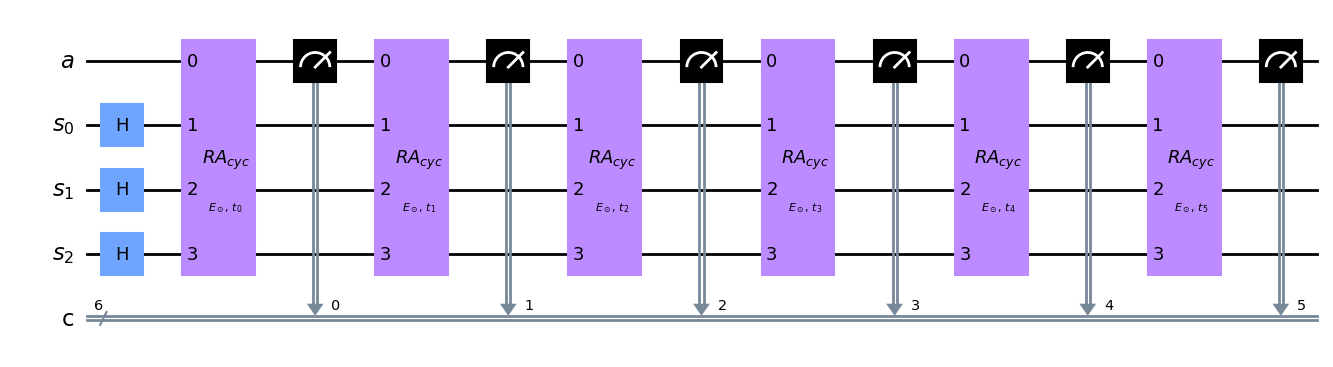

In [3]:
# General parameters
cycles = 6
sys_size = 3

# Circuit parameters
targ = Parameter(r'$E_\odot$')
t = [Parameter(fr'$t_{i}$') for i in range(cycles)]

# Hamiltonian parameters
ham_params = [1]*sys_size

# Create registers and initialize circuit
cbits = ClassicalRegister(cycles, 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(sys_size, 's')
circ = QuantumCircuit(cbits, aux, sys)

# State prep
circ.h(sys)

# Iteratively construct full rodeo circuit
for cyc in range(cycles):
    circ.append(rodeo_cycle(zsum, t[cyc], targ, sys_size, ham_params), range(1 + sys_size))
    circ.measure(aux, cbits[cyc])
circ.draw(output= 'mpl')

## Constuct noise model, backend, Runtime sampler

May be helpful: 

https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/noisy_simulators.html
https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html

In [4]:
# Import noise model 
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_ibm_runtime import Sampler, QiskitRuntimeService, Session, Options

In [5]:
# Construct Sampler
service = QiskitRuntimeService(channel="ibm_quantum")
backend = "ibmq_qasm_simulator"
session = Session(service = service, backend = backend)

## Do a noiseless and noisy Rodeo scan

In [6]:
# Enumerate scan energies
energymin = -5
energymax = 5
stepsize = .1

targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))
targetenergynum = len(targetenergies)
print("Number of target energies:", targetenergynum)

# Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma parameter
gamma = 10 * stepsize

# Amount of "scrambling" of t per target energy. The more random the t the better. 
timeresamples = 10 # Resampling of times for given target energy
shots_per_same_time = 100

# Package parameters into runs of rodeo circuit
params = []
for i, energy in enumerate(targetenergies):
    for j in range(timeresamples):
        tsamples = (1/gamma * np.random.randn(cycles)).tolist() # Choose random t samples
        params = params + [[targetenergies[i]] + tsamples] # Append parameters to params list
runs = len(params)
print("Parameter list generated! Number of unique circuits:", runs)

Number of target energies: 100
Parameter list generated! Number of unique circuits: 1000


In [7]:
# List of noise model parameters
depolarize_probs = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
data = []

for p in depolarize_probs:
    
    # Initialize noise model
    noise_model = NoiseModel()
    error = depolarizing_error(p, 1)
    noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

    options = Options()
    options.simulator = {"noise_model": noise_model}
    sampler = Sampler(session=session, options = options)

    
    # Execute circuit with bound parameters
    print("Executing with noise parameter ", p)
    job = sampler.run([circ]*runs, params, shots = shots_per_same_time)
    result = job.result()
    probs = result.quasi_dists
    allzeroprob = extract_rodeo_success(probs)
    allzeroprob = np.array(allzeroprob).reshape((targetenergynum, timeresamples)).sum(axis=1)/timeresamples
    data += [allzeroprob]

print("Data acquired!")

Executing with noise parameter  0.0
Executing with noise parameter  0.01
Executing with noise parameter  0.02
Executing with noise parameter  0.03
Executing with noise parameter  0.04
Executing with noise parameter  0.05
Data acquired!


## Plot results

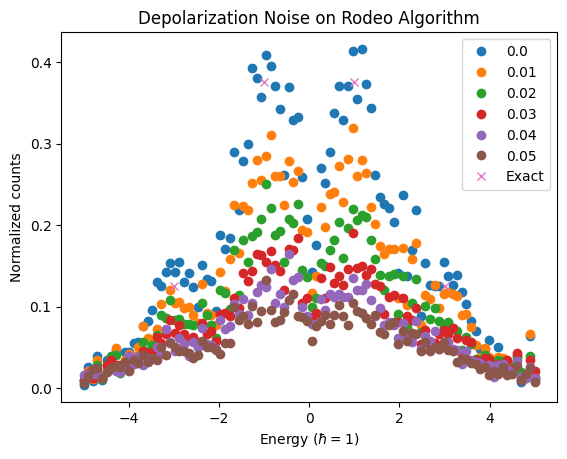

In [27]:
# Plot results
for i, p in enumerate(depolarize_probs):
    plt.plot(targetenergies, data[i], linestyle = 'None', marker = 'o')
plt.plot([-3,-1,1,3],[.125,.375,.375,.125],linestyle = 'None', marker = 'x')
plt.ylabel("Normalized counts")
plt.xlabel(r"Energy ($\hbar = 1$)")
plt.legend([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, "Exact"])
plt.title("Depolarization Noise on Rodeo Algorithm")
fig = plt.gcf()
plt.show()

## Save it?

In [29]:
fig.savefig("RodeoScanDepolarization.png")

In [ ]:
noise_model = NoiseModel()
error = depolarizing_error(p, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])
sampler.options.simulator = {"noise_model": noise_model}
sampler.options.optimization_level = 2
sampler.options.optimization_level